# Implementation

In [ ]:
import torch
import torch.nn as tnn
import torchvision as tvision
import torch.optim as toptim

import PIL as pl
import matplotlib.pyplot as plt

import math

In [16]:
# Setup a config parameter for automaticaly choosing between CPU/GPU compute depending on whether a NVIDIA CUDA capable GPU is present
COMPUTE_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.device(COMPUTE_DEVICE)

device(type='cpu')

In [ ]:
# Setup dataset parameters and training hyperparameters
TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 1000
MEAN = 0.5
STD_DEV = 0.5
EPOCHS = 10
BASE_LEARNING_RATE = 0.001
LEARNING_RATE_GAMMA = 0.1
LEARNING_RATE_STEP_SIZE = 2

In [15]:
# Calculate the mean and std dev from the dataset
train_set = tvision.datasets.MNIST(root="./trainingdata", train=True, transform=tvision.transforms.ToTensor(), download=True)

flattened_data = torch.stack([img for img, _ in train_set])

MEAN = flattened_data.view(1, -1).mean(dim=1).item()
STD_DEV = flattened_data.view(1, -1).std(dim=1).item()

print(f"MEAN: {MEAN}")
print(f"STD_DEV: {STD_DEV}")

MEAN: 0.13066047430038452
STD_DEV: 0.30810782313346863


In [17]:
train_transforms = tvision.transforms.Compose(
    [
        tvision.transforms.ToTensor(),
        tvision.transforms.RandomRotation(90),
        tvision.transforms.Normalize(MEAN, STD_DEV)
    ]
)

eval_transforms = tvision.transforms.Compose(
    [
        tvision.transforms.ToTensor(),
        tvision.transforms.Normalize(MEAN, STD_DEV)
    ]
)

In [19]:
# Load the dataset
training_set = tvision.datasets.MNIST(root="./trainingdata", train=True, transform=train_transforms, download=True)
evaluation_set = tvision.datasets.MNIST(root="./evaluationdata", train=False, transform=eval_transforms, download=True)

training_set_loader = torch.utils.data.DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
evaluation_set_loader = torch.utils.data.DataLoader(evaluation_set, batch_size=EVAL_BATCH_SIZE, shuffle=False)

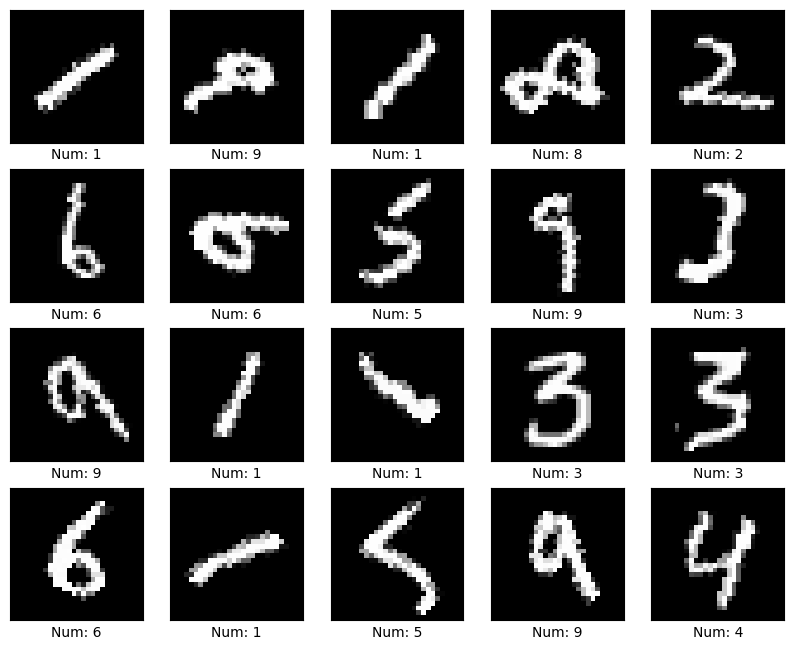

In [20]:
# Get a copy of the data loader so that it can be iterated without affecting the model
train_set_imgs, train_set_labels = next(iter(training_set_loader))

# Display a few samples

plt.figure(figsize=(10, 10))

for i in range(20):
    img = train_set_imgs[i]
    lbl = train_set_labels[i]

    plt.subplot(5, 5, i + 1)
    plt.xlabel(f"Num: {lbl}")
    plt.imshow(img.numpy().squeeze(), cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

In [ ]:
# Setup the model layers
model = tnn.Sequential(
    tnn.Conv2d(1, 16, 3, 1, 1),
    tnn.BatchNorm2d(16),
    tnn.ReLU(),
    tnn.MaxPool2d(2, 2),

    tnn.Conv2d(16, 32, 3, 1, 1),
    tnn.BatchNorm2d(32),
    tnn.ReLU(),
    tnn.MaxPool2d(2, 2),

    tnn.Flatten(),
    tnn.Linear(32 * 7 * 7, 128), # img is 7x7 after going through two 2x2 pooling layers
    tnn.ReLU,
    tnn.Dropout(0.2),
    tnn.Linear(128, 10)
).to(COMPUTE_DEVICE)

In [ ]:
# Setup optimizer, loss and learning rate scheduler functions
loss_func = tnn.CrossEntropyLoss()
optimizer = toptim.Adam(model.parameters(), lr=BASE_LEARNING_RATE)
lr_sched = toptim.lr_scheduler.StepLR(optimizer=optimizer, gamma=LEARNING_RATE_GAMMA, step_size=LEARNING_RATE_STEP_SIZE)

In [ ]:
# Model training
